<a href="https://colab.research.google.com/github/Thiashopy04/PROSES-MINING/blob/main/BAGIAN_F_%E2%80%94_Performance_%26_Bottleneck_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pm4py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.dfg import visualizer as dfg_visualizer

In [3]:
df = pd.read_csv('/content/1767518350948_event_log_rumah_sakit_sintetis.csv')
df.head()

,case_id,activity,timestamp,resource,lifecycle,department,insurance_type,severity,cost_idr,variant
0,RS-00001,Pendaftaran,2025-12-11 19:17:08,Admin-01,complete,IGD,BPJS,Ringan,12290,rawat_jalan_sederhana
1,RS-00001,Triage,2025-12-11 19:53:08,Perawat-01,complete,IGD,BPJS,Ringan,0,rawat_jalan_sederhana
2,RS-00001,Pemeriksaan Dokter,2025-12-11 20:14:08,Dokter-Umum-01,complete,IGD,BPJS,Ringan,38944,rawat_jalan_sederhana
3,RS-00001,Resep Obat,2025-12-11 20:32:08,Dokter-Umum-02,complete,IGD,BPJS,Ringan,0,rawat_jalan_sederhana
4,RS-00001,Pembayaran,2025-12-11 21:15:08,Kasir-03,complete,IGD,BPJS,Ringan,0,rawat_jalan_sederhana


In [4]:
# timestamp → datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# urutkan event
df = df.sort_values(['case_id', 'timestamp'])

# rename kolom PM4Py
df_pm = df.rename(columns={
    'case_id': 'case:concept:name',
    'activity': 'concept:name',
    'timestamp': 'time:timestamp',
    'resource': 'org:resource'
})

df_pm = dataframe_utils.convert_timestamp_columns_in_df(df_pm)

# konversi ke event log
event_log = log_converter.apply(df_pm)

In [5]:
df['next_timestamp'] = df.groupby('case_id')['timestamp'].shift(-1)

df['waiting_time_hours'] = (
    df['next_timestamp'] - df['timestamp']
).dt.total_seconds() / 3600

df.head()

,case_id,activity,timestamp,resource,lifecycle,department,insurance_type,severity,cost_idr,variant,next_timestamp,waiting_time_hours
0,RS-00001,Pendaftaran,2025-12-11 19:17:08,Admin-01,complete,IGD,BPJS,Ringan,12290,rawat_jalan_sederhana,2025-12-11 19:53:08,0.600000
1,RS-00001,Triage,2025-12-11 19:53:08,Perawat-01,complete,IGD,BPJS,Ringan,0,rawat_jalan_sederhana,2025-12-11 20:14:08,0.350000
2,RS-00001,Pemeriksaan Dokter,2025-12-11 20:14:08,Dokter-Umum-01,complete,IGD,BPJS,Ringan,38944,rawat_jalan_sederhana,2025-12-11 20:32:08,0.300000
3,RS-00001,Resep Obat,2025-12-11 20:32:08,Dokter-Umum-02,complete,IGD,BPJS,Ringan,0,rawat_jalan_sederhana,2025-12-11 21:15:08,0.716667
4,RS-00001,Pembayaran,2025-12-11 21:15:08,Kasir-03,complete,IGD,BPJS,Ringan,0,rawat_jalan_sederhana,2025-12-12 07:48:34,10.557222


In [6]:
avg_waiting = (
    df.groupby('activity')['waiting_time_hours']
    .mean()
    .sort_values(ascending=False)
)

avg_waiting.head(5)

,waiting_time_hours
activity,
Tindakan,16.110902
Rawat Inap,4.437729
Pemeriksaan Lab,3.981550
Radiologi,3.446175
Pemeriksaan Dokter,1.716731


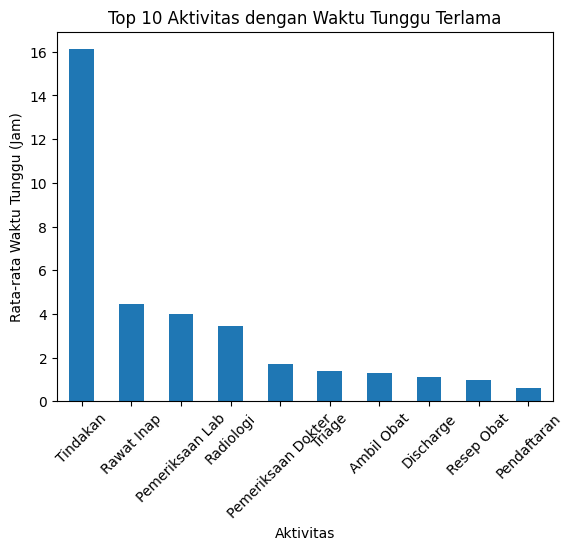

In [7]:
avg_waiting.head(10).plot(kind='bar')
plt.title('Top 10 Aktivitas dengan Waktu Tunggu Terlama')
plt.xlabel('Aktivitas')
plt.ylabel('Rata-rata Waktu Tunggu (Jam)')
plt.xticks(rotation=45)
plt.show()

In [8]:
resource_busy = df['resource'].value_counts()
resource_busy.head()

,count
resource,
System,600
Dokter-Umum-02,308
Dokter-Umum-01,306
Dokter-Umum-03,302
Dokter-Umum-04,298


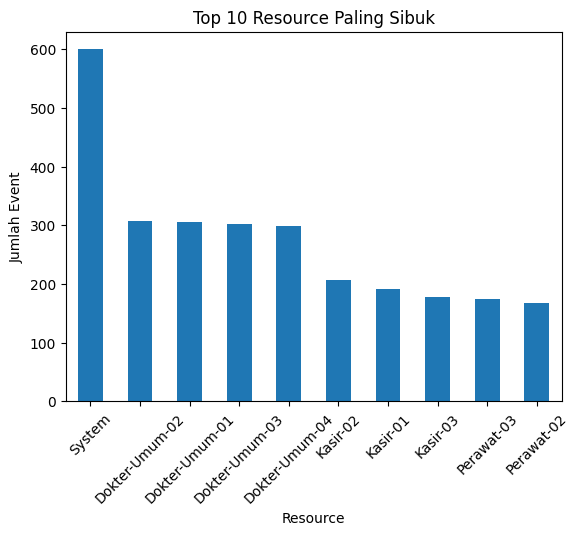

In [9]:
resource_busy.head(10).plot(kind='bar')
plt.title('Top 10 Resource Paling Sibuk')
plt.xlabel('Resource')
plt.ylabel('Jumlah Event')
plt.xticks(rotation=45)
plt.show()

In [10]:
top_resources = resource_busy.head(2).index.tolist()
top_resources

['System', 'Dokter-Umum-02']

In [11]:
case_resource = df[df['resource'].isin(top_resources)]

case_duration = (
    case_resource.groupby(['case_id', 'resource'])['timestamp']
    .agg(['min', 'max'])
)

case_duration['duration_hours'] = (
    case_duration['max'] - case_duration['min']
).dt.total_seconds() / 3600

case_duration.groupby('resource')['duration_hours'].mean()

,duration_hours
resource,
Dokter-Umum-02,0.400479
System,0.000000


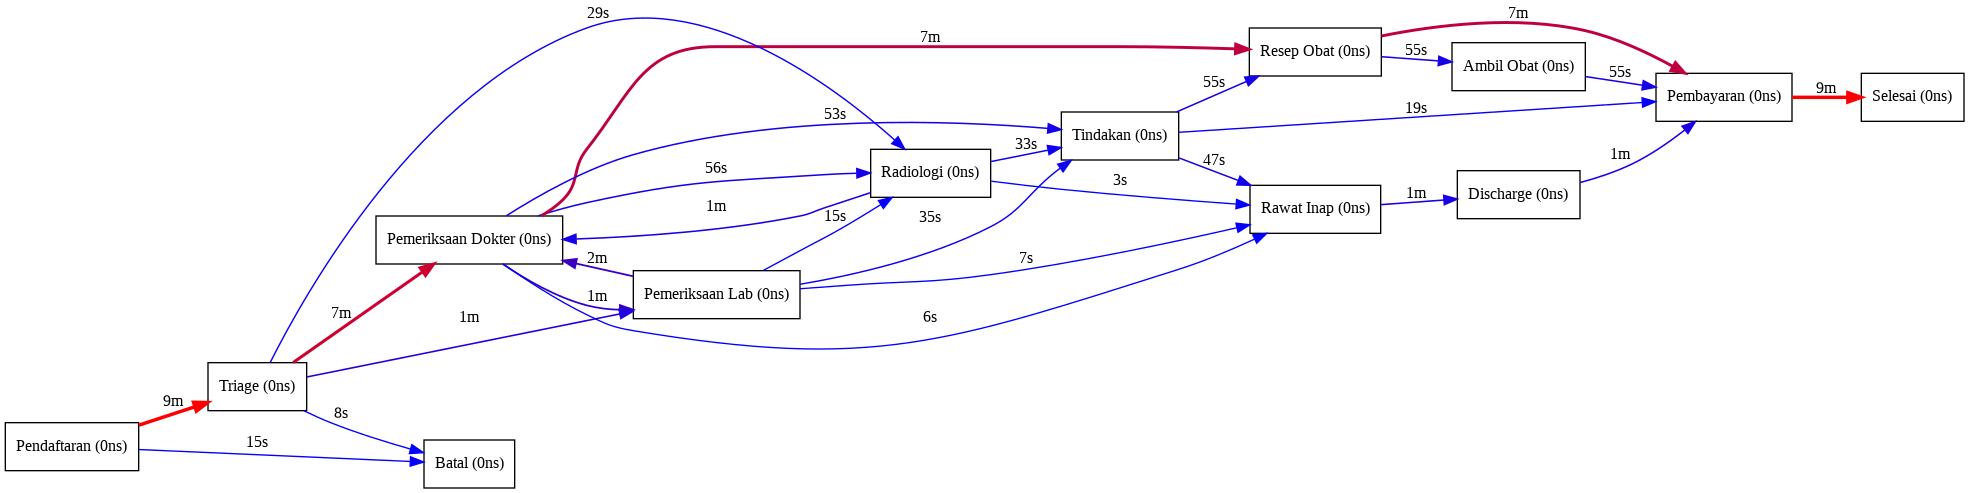

In [13]:
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

dfg = dfg_discovery.apply(event_log)

gviz = dfg_visualizer.apply(
    dfg,
    log=event_log,
    variant=dfg_visualizer.Variants.PERFORMANCE
)

dfg_visualizer.view(gviz)

✍️ Narasi Laporan

Analisis performa proses menunjukkan bahwa beberapa aktivitas memiliki waktu tunggu rata-rata yang lebih tinggi dibandingkan aktivitas lainnya, yang mengindikasikan adanya bottleneck dalam alur pelayanan rumah sakit.
Selain itu, analisis resource menunjukkan adanya resource yang memiliki beban kerja lebih tinggi.
Perbandingan durasi case antar resource memperlihatkan perbedaan efisiensi dalam penyelesaian layanan, yang dapat menjadi dasar evaluasi distribusi tugas dan sumber daya.


Visualisasi Directly-Follows Graph (DFG) berbasis performance digunakan untuk mengidentifikasi hubungan aktivitas dan durasi waktu antar aktivitas dalam proses layanan rumah sakit.